Setup

In [16]:
# Load libraries
library(simmer)
library(simmer.plot)
library(tidyverse)

# Set seed for reproducibility
set.seed(42)

In [34]:
# Load MIMIC-IV data

# Define data directory
data_dir <- "~/Desktop/MIMIC_ED/processed/"

# Load all four tables
ed_stays <- read_csv(paste0(data_dir, "ed_stays.csv"))
ed_activities <- read_csv(paste0(data_dir, "ed_activity_log.csv"))
ed_diagnoses <- read_csv(paste0(data_dir, "ed_diagnoses.csv"))
ed_medications <- read_csv(paste0(data_dir, "ed_medications.csv"))

Rows: 425028 Columns: 14
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): gender, race, arrival_transport, disposition, chiefcomplaint
dbl  (5): stay_id, subject_id, hadm_id, acuity, ed_los_hours
lgl  (1): is_admitted
dttm (3): arrival_time, triage_time, depart_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3737756 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): activity
dbl  (5): stay_id, subject_id, hadm_id, acuity, activity_seq
dttm (1): timestamps

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 898730 Columns: 5
── Column specification ──────────────────────────────────


=== DATA QUALITY CHECKS ===
Inconsistent records (disposition=ADMITTED but is_admitted=FALSE): 0 

=== COHORT SUMMARY ===
Total ED visits: 425,028 
Admitted patients: 158,010 ( 37.2 %)

=== LOS DISTRIBUTION (Admitted Patients) ===
Minutes:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   260.0   374.0   436.6   527.0 29584.2 

Hours:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.01667   4.33333   6.23333   7.27716   8.78333 493.06944 

=== TRANSFER THRESHOLD (for Phase 2) ===
80th percentile: 573 minutes ( 9.55 hours)


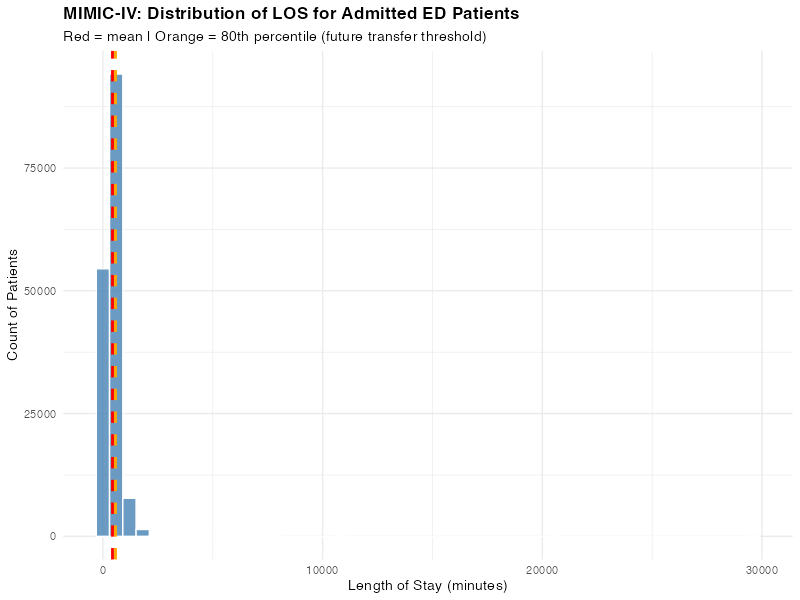

In [35]:
# DATA CLEANING FOR ED SIMULATION

# Filter for admitted patients only
ed_admitted <- ed_stays %>%
  filter(is_admitted == TRUE) %>%
  mutate(
    los_minutes = ed_los_hours * 60,
    los_minutes = if_else(is.na(los_minutes) | los_minutes <= 0, 
                          median(los_minutes, na.rm = TRUE), 
                          los_minutes)
  )

# Check for inconsistencies
inconsistencies <- ed_stays %>%
  filter(disposition == "ADMITTED" & is_admitted == FALSE) %>%
  nrow()

cat("\n=== DATA QUALITY CHECKS ===\n")
cat("Inconsistent records (disposition=ADMITTED but is_admitted=FALSE):", inconsistencies, "\n")

# Overall statistics
total_visits <- nrow(ed_stays)
total_admitted <- nrow(ed_admitted)
admission_rate <- round(100 * total_admitted / total_visits, 1)

cat("\n=== COHORT SUMMARY ===\n")
cat("Total ED visits:", format(total_visits, big.mark = ","), "\n")
cat("Admitted patients:", format(total_admitted, big.mark = ","), 
    "(", admission_rate, "%)\n")

# LOS distribution for admitted patients
cat("\n=== LOS DISTRIBUTION (Admitted Patients) ===\n")
cat("Minutes:\n")
print(summary(ed_admitted$los_minutes))
cat("\nHours:\n")
print(summary(ed_admitted$ed_los_hours))

# Calculate 80th percentile threshold
los_threshold_80 <- quantile(ed_admitted$los_minutes, 0.80, na.rm = TRUE)
cat("\n=== TRANSFER THRESHOLD (for Phase 2) ===\n")
cat("80th percentile:", round(los_threshold_80, 2), "minutes")
cat(" (", round(los_threshold_80/60, 2), "hours)\n")

# Visualize real MIMIC distribution
ggplot(ed_admitted, aes(x = los_minutes)) +
  geom_histogram(bins = 50, fill = "steelblue", color = "white", alpha = 0.8) +
  geom_vline(aes(xintercept = mean(los_minutes, na.rm = TRUE)), 
             color = "red", linetype = "dashed", linewidth = 1) +
  geom_vline(aes(xintercept = los_threshold_80), 
             color = "orange", linetype = "dashed", linewidth = 1) +
  labs(
    title = "MIMIC-IV: Distribution of LOS for Admitted ED Patients",
    subtitle = "Red = mean | Orange = 80th percentile (future transfer threshold)",
    x = "Length of Stay (minutes)",
    y = "Count of Patients"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold"))

Parameters

In [40]:
# Resource capacities (start with infinite as Karandeep suggested)
ED_BED_CAPACITY <- Inf

# Time distributions using MIMIC IV data
los_time <- function() sample(ed_admitted$los_minutes, 1)

# Arrival rate (placeholder, used Karandeep's code ~3.33 patients per hour)
arrival_interval <- function() rexp(1, 1/(18/60))

# Store the transfer threshold for Phase 2
LOS_TRANSFER_THRESHOLD <- los_threshold_80

cat("   - LOS: Sampling from", format(nrow(ed_admitted), big.mark = ","), 
    "admitted patient records\n")
cat("   - Mean LOS:", round(mean(ed_admitted$los_minutes), 1), "minutes",
    "(", round(mean(ed_admitted$los_minutes)/60, 2), "hours)\n")
cat("   - Transfer threshold:", round(LOS_TRANSFER_THRESHOLD, 1), "minutes",
    "(", round(LOS_TRANSFER_THRESHOLD/60, 2), "hours)\n")

   - LOS: Sampling from 158,010 admitted patient records
   - Mean LOS: 436.6 minutes ( 7.28 hours)
   - Transfer threshold: 573 minutes ( 9.55 hours)


Patient Trajectory

In [41]:
# Define patient flow through ED
patient_trajectory <- trajectory("ED patient flow") %>%
  seize("ed_bed", 1) %>%              # Patient occupies ED bed
  timeout(los_time) %>%               # Stay for length of stay
  release("ed_bed", 1)                # Leave ED (disposition)

Build Sim Environment

In [42]:
# Create environment
ed_sim <- simmer("ED Simulation V1")

# Add resources
ed_sim %>%
  add_resource("ed_bed", capacity = ED_BED_CAPACITY)

# Add patient generator
ed_sim %>%
  add_generator("patient", patient_trajectory, arrival_interval, mon = 2)

simmer environment: ED Simulation V1 | now: 0 | next: 0
{ Monitor: in memory }
{ Resource: ed_bed | monitored: TRUE | server status: 0(Inf) | queue status: 0(Inf) }
{ Source: patient | monitored: 2 | n_generated: 0 }

Run Sim

In [43]:
# Run for 24 hours (1440 minutes)
ed_sim %>% run(until = 1440)

# Check final time
simmer::now(ed_sim)

[1] 1440

Extract Results

In [44]:
# Get monitoring data
arrivals <- get_mon_arrivals(ed_sim)
resources <- get_mon_resources(ed_sim)

# Quick summary
summary(arrivals$activity_time)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    6.0   234.5   334.0   362.2   457.2  1418.0 

Visualizations

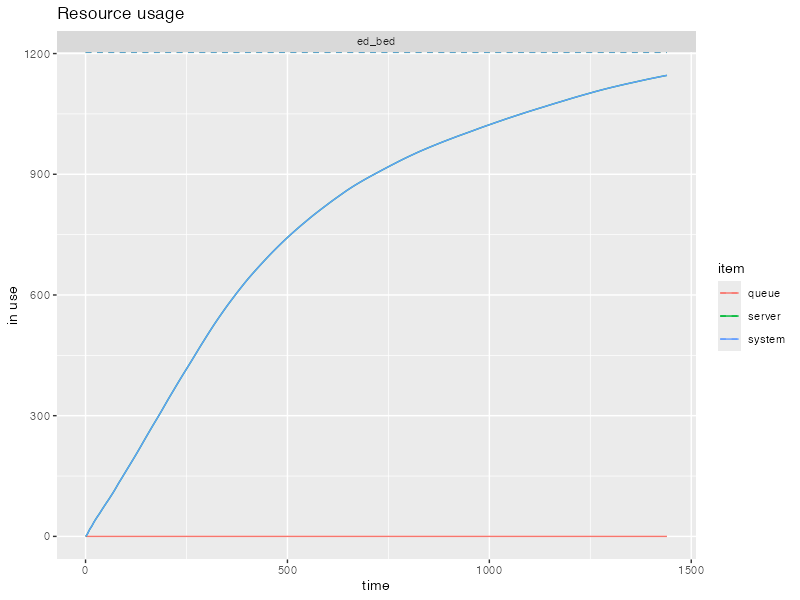

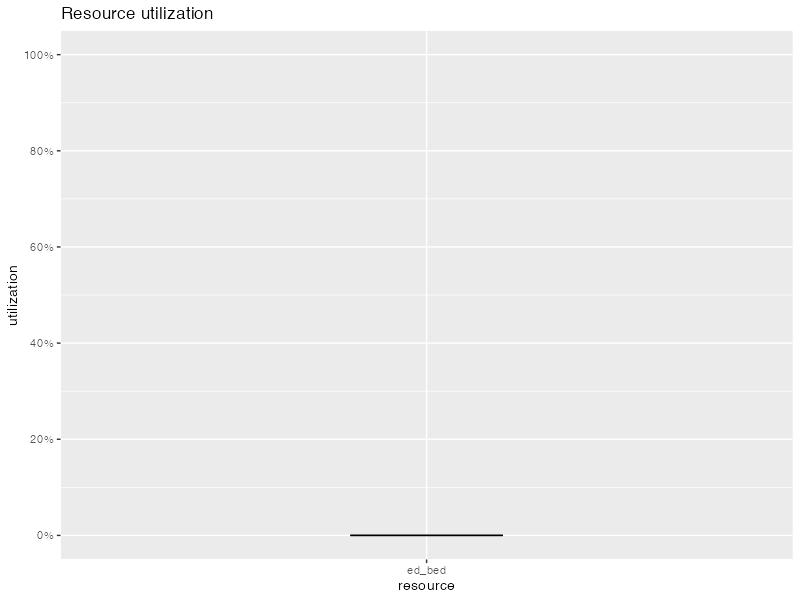

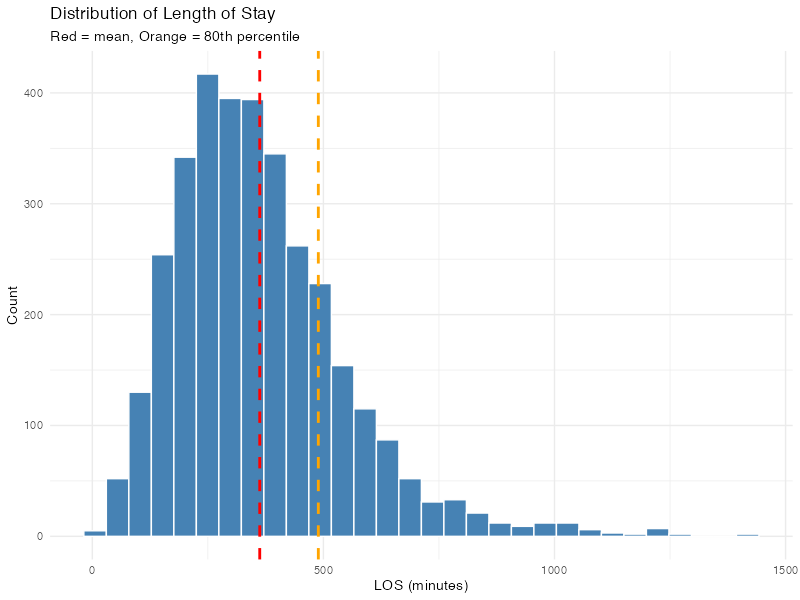

In [45]:
# Plot resource usage over time
plot(resources, metric = "usage")

# Plot resource utilization
plot(resources, metric = "utilization")

# Histogram of length of stay
ggplot(arrivals, aes(x = activity_time)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  geom_vline(aes(xintercept = mean(activity_time)), 
             color = "red", linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = quantile(activity_time, 0.80)), 
             color = "orange", linetype = "dashed", size = 1) +
  labs(
    title = "Distribution of Length of Stay",
    subtitle = "Red = mean, Orange = 80th percentile",
    x = "LOS (minutes)",
    y = "Count"
  ) +
  theme_minimal()